<a href="https://colab.research.google.com/github/Maruf346/AI-ML-with-python/blob/main/SVM_model_for_Dengue_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preview:
         date location  rainfall_mm  humidity_percent  temp_min_C  temp_max_C  \
0  2022-08-14    Delhi          9.9             68.78        26.1        32.9   
1  2022-08-15    Delhi          0.3             68.27        25.9        31.0   
2  2022-08-16    Delhi          8.7             70.09        25.7        30.7   
3  2022-08-17    Delhi          0.2             64.71        25.2        31.9   
4  2022-08-18    Delhi          0.5             62.39        25.5        33.5   

   temp_mean_C  wind_speed_kph  wind_direction_deg  uv_index       pm25  \
0         28.1            20.2                 247      0.02  53.270833   
1         28.1            17.2                  71      0.03  37.062500   
2         27.6            33.5                  98      0.02  24.050000   
3         28.3            22.9                 135      0.04  26.370833   
4         29.2            14.0                 229      0.04  41.362500   

        pm10  aqi      risk  
0  79.366667  145 

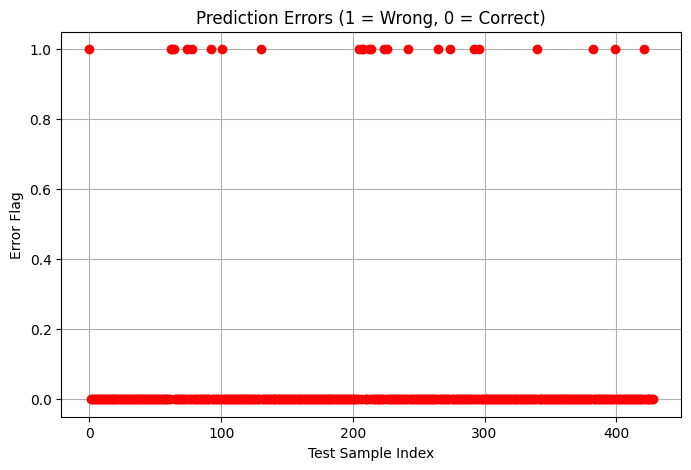

Model saved as svm_weather_model.pkl


In [3]:
# =============================
#  STEP 1: Install dependencies
# =============================
#!pip install scikit-learn pandas matplotlib

# =============================
#  STEP 2: Import Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib  # to save the model later

# =============================
#  STEP 3: Load CSV File
# =============================
# Upload CSV in Colab's file explorer OR use path if it's in Drive
csv_path = "prediction_dataset_with_risk.csv"  # Change to your CSV filename
df = pd.read_csv(csv_path)

print("Data Preview:")
print(df.head())

# =============================
#  STEP 4: Define Features & Target
# =============================
# Example: Assume 'risk' is the target column
target_column = "risk"  # change to your target column
X = df.drop(columns=[target_column])
y = df[target_column]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

# =============================
#  STEP 5: Train-Test Split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================
#  STEP 6: Preprocessing Pipelines
# =============================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# =============================
#  STEP 7: Define SVM Model & Hyperparameter Search
# =============================
svm = SVC(kernel="rbf", class_weight="balanced", probability=True)

param_dist = {
    "C": np.logspace(-2, 2, 10),
    "gamma": np.logspace(-2, 2, 10)
}

svm_search = RandomizedSearchCV(
    svm, param_distributions=param_dist, n_iter=5, scoring="accuracy", cv=3, random_state=42
)

# =============================
#  STEP 8: Pipeline + Fit
# =============================
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", svm_search)
])

clf.fit(X_train, y_train)

# =============================
#  STEP 9: Predictions & Errors
# =============================
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# =============================
#  STEP 10: Plot Error Analysis
# =============================
errors = (y_pred != y_test).astype(int)

plt.figure(figsize=(8, 5))
plt.plot(range(len(errors)), errors, marker='o', linestyle='', color='red')
plt.title("Prediction Errors (1 = Wrong, 0 = Correct)")
plt.xlabel("Test Sample Index")
plt.ylabel("Error Flag")
plt.grid(True)
plt.show()

# =============================
#  STEP 11: Save Model (for Django later)
# =============================
joblib.dump(clf, "svm_weather_model.pkl")
print("Model saved as svm_weather_model.pkl")
